In [1]:
import os
os.chdir('..')  # Mueve el directorio de trabajo un nivel arriba



In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.misc import derivative
from functions_master import *
import warnings

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def FourierT2(f,N):
    return np.conj(sp.fft.fft(f.values,n=N))


In [13]:
# Configuración desde el archivo txt (simulada aquí como un diccionario)
config = {
    'figure.constrained_layout.use': True,
    'figure.figsize': (5.4, 3.2),
    'figure.titlesize': 'small',
    'figure.labelsize': 'small',
    'font.size': 10,
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.texsystem': 'lualatex',
    'pgf.rcfonts': False,
    'pgf.preamble': r'\usepackage{siunitx,fontspec}\setmainfont{Times New Roman}',
    'lines.linewidth': 1,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 4,
    'legend.frameon': False,
    'legend.markerscale': 0.8,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.2,
    'xtick.top': True,
    'xtick.major.size': 5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.8,
    'xtick.minor.size': 3,
    'xtick.labelsize': 'small',
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.major.size': 5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.8,
    'ytick.minor.size': 3,
    'ytick.labelsize': 'small',
    'ytick.direction': 'in',
    'axes.linewidth': 0.8,
    'axes.axisbelow': False,
    'axes.labelsize': 'medium',
    'axes.labelpad': 2,
    'figure.constrained_layout.h_pad': 0.02,
    'figure.constrained_layout.w_pad': 0.01,
    'figure.constrained_layout.hspace': 0.02,
    'figure.constrained_layout.wspace': 0.02,
    'svg.fonttype': 'none'
}

# Aplicar la configuración
plt.rcParams.update(config)

In [ ]:
x1,x2 = 0.15,1.05

path_air1 = r'C:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\paper_window\Air+Water'
archivos = os.listdir(path_air1)

labels = [extraer_humedad(nombre_archivo) for nombre_archivo in archivos]
# Filtrar solo archivos (excluyendo carpetas)
archivos = [os.path.join(path_air1, archivo) for archivo in archivos if os.path.isfile(os.path.join(path_air1, archivo))]

C:\Users\esmaru\AppData\Local\Temp\ipykernel_30624\928100976.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


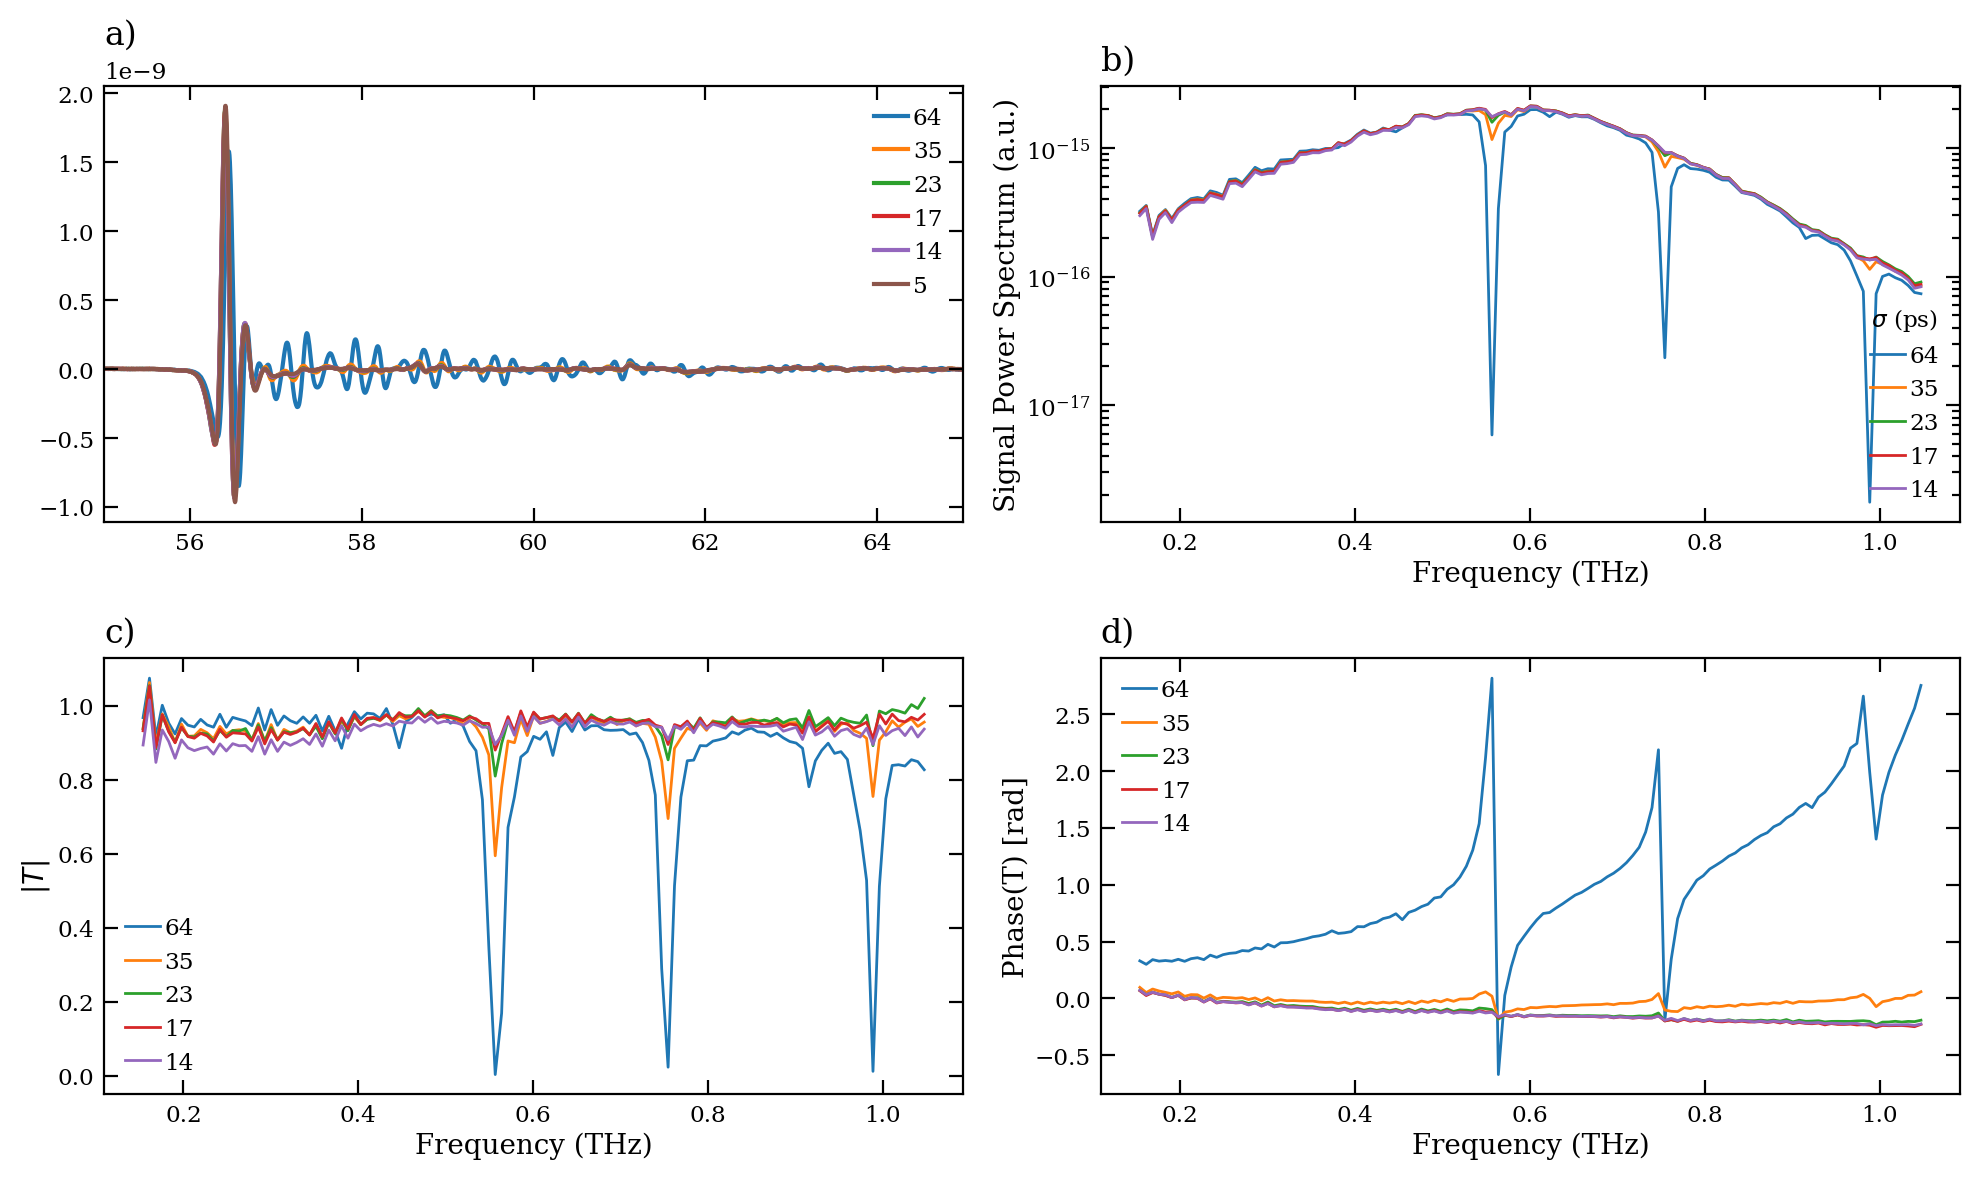

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

f, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=200)  # 2 filas, 2 columnas
axs = axs.flatten()  # aplanamos para indexar más fácil
N = 2**12

x_ref, y_ref = getFilterdata(archivos[-1], right=None, left=None)

for cc, path_archiv in enumerate(archivos):

    # --- Señal temporal ---
    x, y = getFilterdata(path_archiv, right=None, left=None)
    ax = axs[0]
    ax.plot(x, y, label=int(labels[cc]), linewidth=1.5)
    ax.set_xlim(min(x), 65)
    ax.set_title('a)', loc='left')
    ax.legend()

    # --- FFT ---
    k = 15
    nu = sp.fft.fftfreq(N, 1/30)

    fft_y_signal = FourierT2(y, N)[1:len(nu)//k]
    fft_y_subs   = FourierT2(y_ref, N)[1:len(nu)//k]

    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.15, 1.05
    mask = (nu >= xmin) & (nu <= xmax)
    nu_filtradas = nu[mask]
    fft_y_signal = fft_y_signal[mask]
    fft_y_subs   = fft_y_subs[mask]

    # Transmitancia
    T = fft_y_signal / fft_y_subs

    # --- Potencia espectral (FFT) ---
    ax = axs[1]
    if cc != len(archivos) - 1:
        ax.plot(nu_filtradas, np.abs(fft_y_signal)**2, label=int(labels[cc]))
        ax.set_ylabel(r'Signal Power Spectrum (a.u.)')
        ax.set_yscale('log')
        ax.set_xlabel(r'Frequency (THz)')
        ax.set_title('b)', loc='left')
        ax.legend(title='$\sigma$ (ps)', loc='lower right')

    # --- |T|^2 ---
    ax = axs[2]
    if cc != len(archivos) - 1:
        ax.plot(nu_filtradas, np.abs(T)**2, label=int(labels[cc]))
        ax.set_ylabel(r'$|T|$')
        ax.set_xlabel(r'Frequency (THz)')
        ax.set_title('c)', loc='left')
        ax.legend()

    # --- Fase(T) ---
    ax = axs[3]
    if cc != len(archivos) - 1:
        phase = np.angle(T)
        ax.plot(nu_filtradas, phase, label=int(labels[cc]))
        ax.set_ylabel(r'Phase(T) [rad]')
        ax.set_xlabel(r'Frequency (THz)')
        ax.set_title('d)', loc='left')
        ax.legend()

plt.tight_layout()
plt.show()


# Prueba Fitting

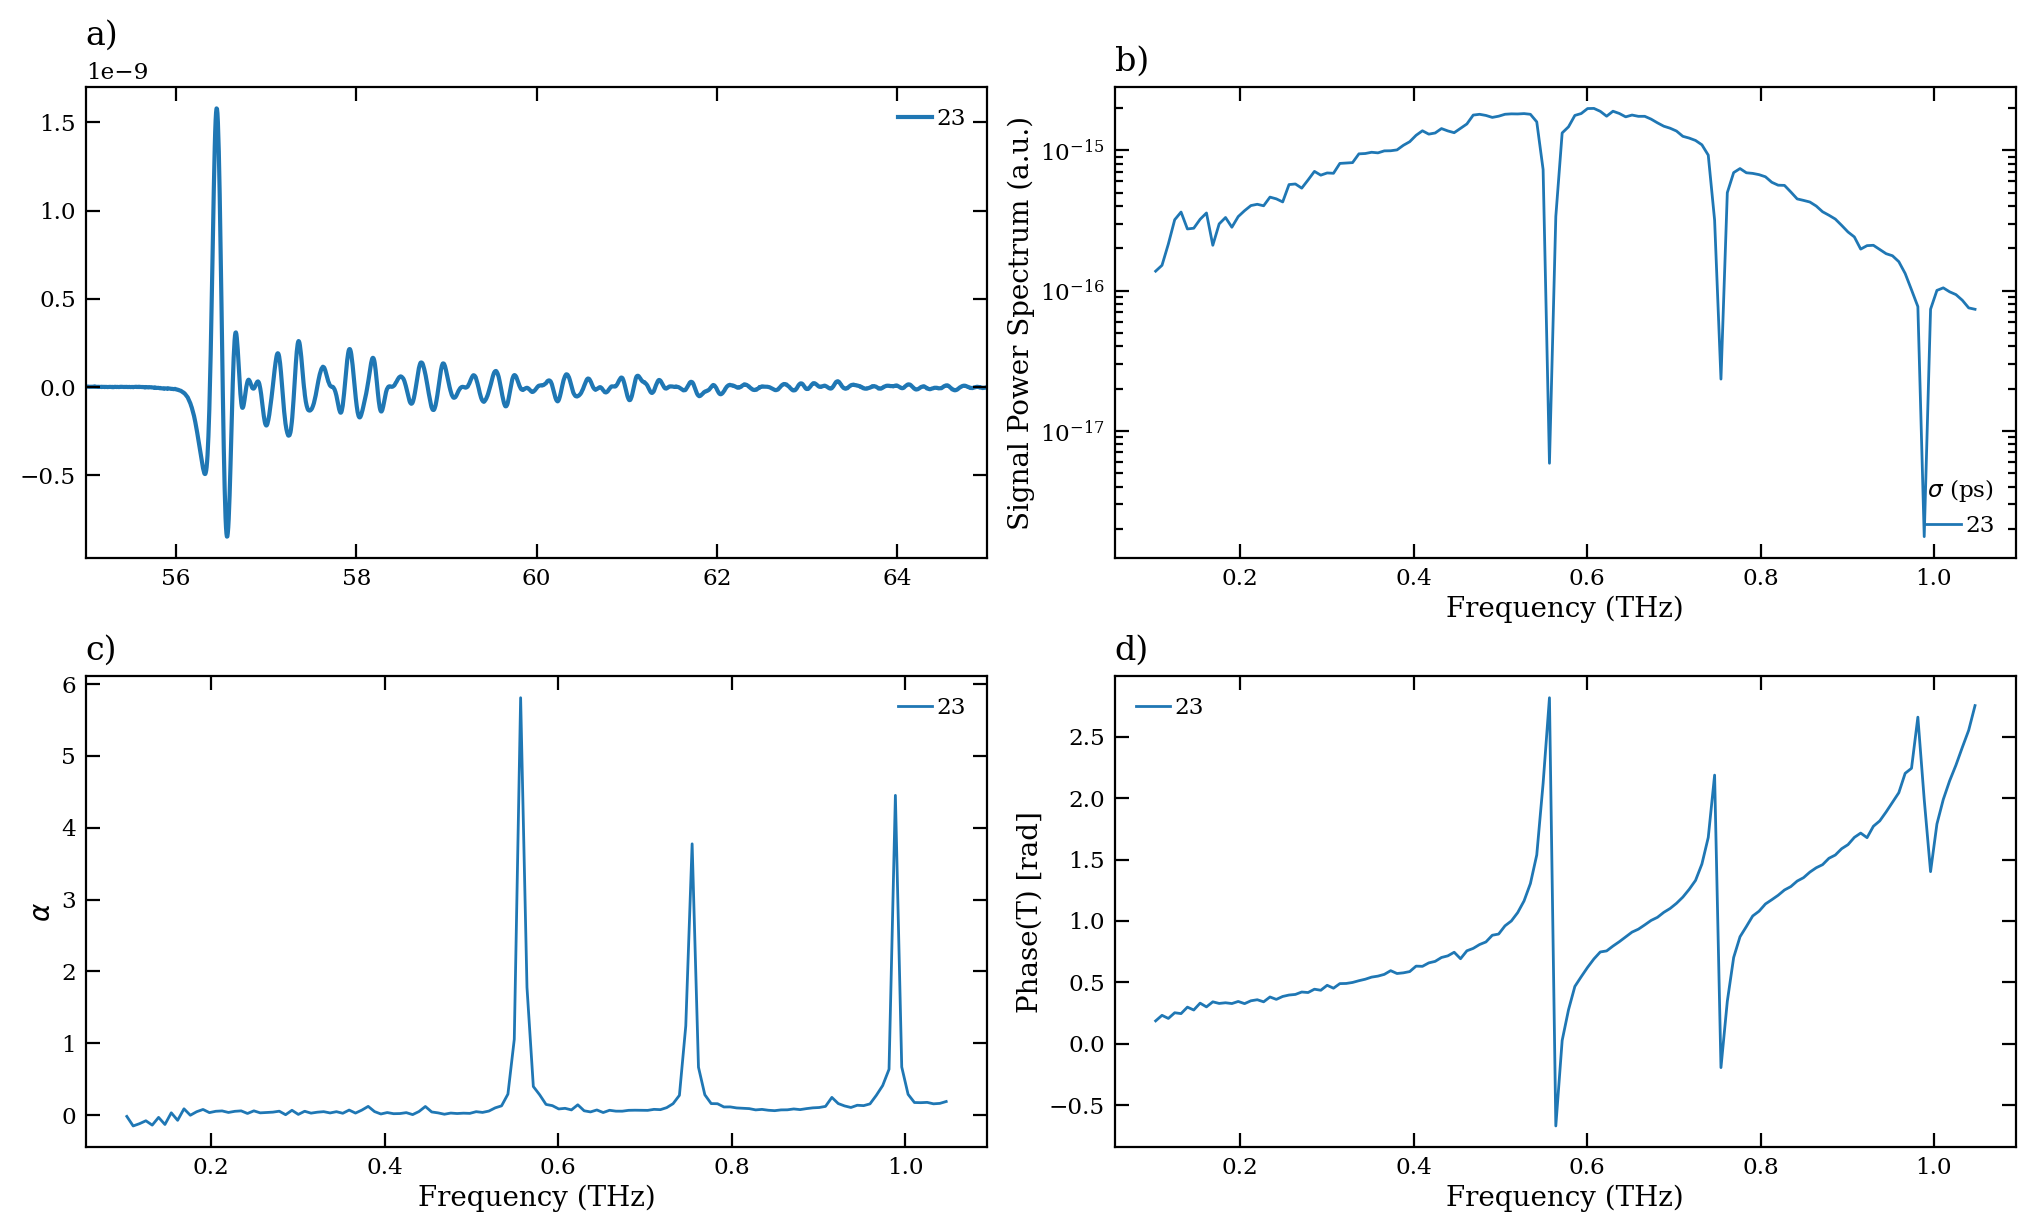

In [122]:
# --- Señal temporal ---
f, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=200)  # 2 filas, 2 columnas
axs = axs.flatten()  # aplanamos para indexar más fácil
path_archiv = archivos[0]  # Usar el primer archivo para la señal temporal
cc = 2
x, y = getFilterdata(path_archiv, right=None, left=None)
ax = axs[0]
ax.plot(x, y, label=int(labels[cc]), linewidth=1.5)
ax.set_xlim(min(x), 65)
ax.set_title('a)', loc='left')
ax.legend()

# --- FFT ---
k = 15
nu = sp.fft.fftfreq(N, 1/30)

fft_y_signal = FourierT2(y, N)[1:len(nu)//k]
fft_y_subs   = FourierT2(y_ref, N)[1:len(nu)//k]

nu = nu[1:len(nu)//k]
xmin, xmax = 0.1, 1.05
mask = (nu >= xmin) & (nu <= xmax)
nu_filtradas = nu[mask]
fft_y_signal = fft_y_signal[mask]
fft_y_subs   = fft_y_subs[mask]

# Transmitancia
T = fft_y_signal / fft_y_subs

# --- Potencia espectral (FFT) ---
ax = axs[1]
if cc != len(archivos) - 1:
    ax.plot(nu_filtradas, np.abs(fft_y_signal)**2, label=int(labels[cc]))
    ax.set_ylabel(r'Signal Power Spectrum (a.u.)')
    ax.set_yscale('log')
    ax.set_xlabel(r'Frequency (THz)')
    ax.set_title('b)', loc='left')
    ax.legend(title='$\sigma$ (ps)', loc='lower right')

# --- |T|^2 ---
ax = axs[2]
if cc != len(archivos) - 1:
    ax.plot(nu_filtradas, -2*np.log(np.abs(T)), label=int(labels[cc]))
    ax.set_ylabel(r'$\alpha$')
    ax.set_xlabel(r'Frequency (THz)')
    ax.set_title('c)', loc='left')
    ax.legend()

# --- Fase(T) ---
ax = axs[3]
if cc != len(archivos) - 1:
    phase = np.angle(T)
    ax.plot(nu_filtradas, phase, label=int(labels[cc]))
    ax.set_ylabel(r'Phase(T) [rad]')
    ax.set_xlabel(r'Frequency (THz)')
    ax.set_title('d)', loc='left')
    ax.legend()

C:\Users\esmaru\AppData\Local\Temp\ipykernel_30624\2200610524.py:113: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


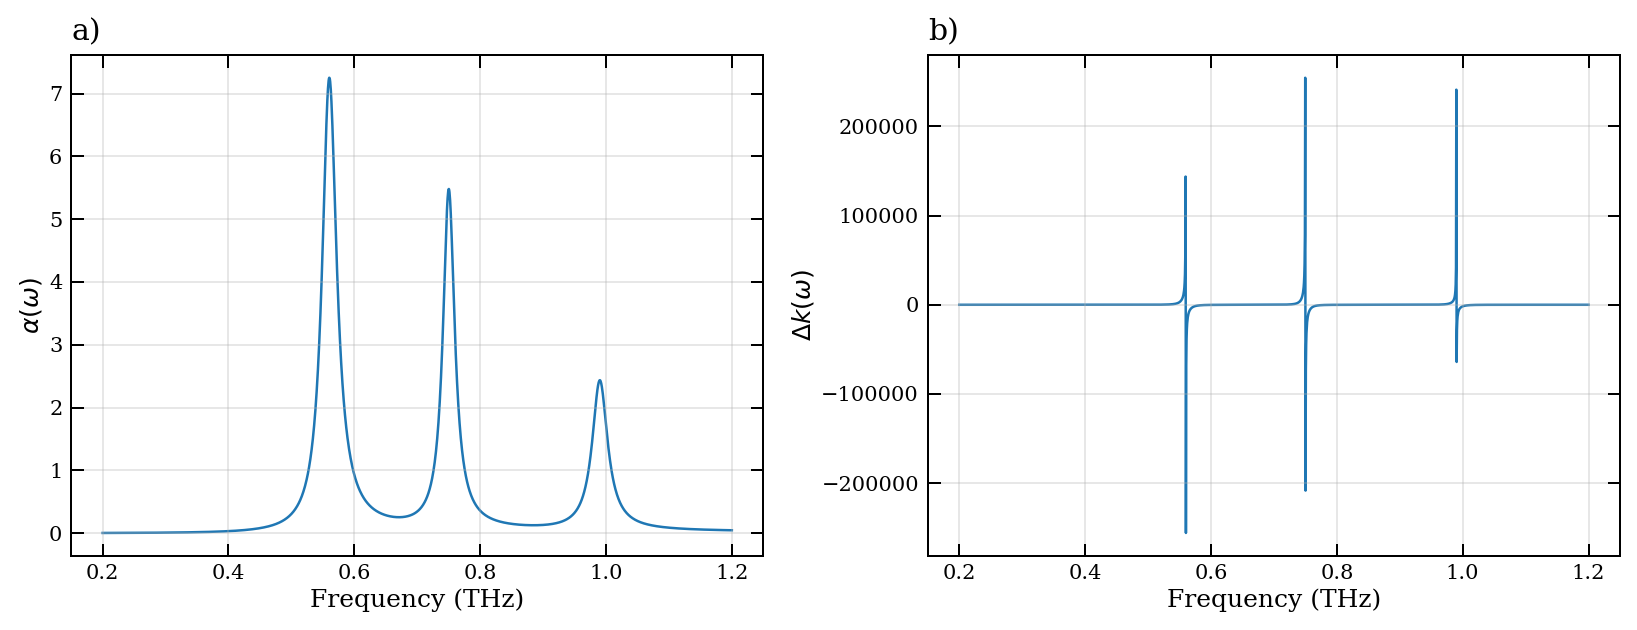

In [127]:
f0 = [0.56, 0.75, 0.99]     # THz
Aj = [1.0, 0.6, 0.35]
gamma_frac = [0.05, 0.03, 0.03]  # Δω_j / ω_j

f, a, dk = plot_alpha_and_delta_k(
    fmin_THz=0.2, fmax_THz=1.2, npts=2000,
    f0_THz=f0, Aj=Aj, dOmega_j_frac=gamma_frac, D=1.0
)


Parámetros ajustados (curve_fit):
f0 (THz)   : [0.55859788 0.74858219 0.98173386]
A_j        : [0.10545931 0.02295892 0.03051611]
gamma_frac : [0.17776868 0.09338317 0.19997731]
D          : 0.015447941419517495


C:\Users\esmaru\AppData\Local\Temp\ipykernel_30624\2282059580.py:146: UserWarning: The figure layout has changed to tight
  plt.tight_layout(); plt.show()


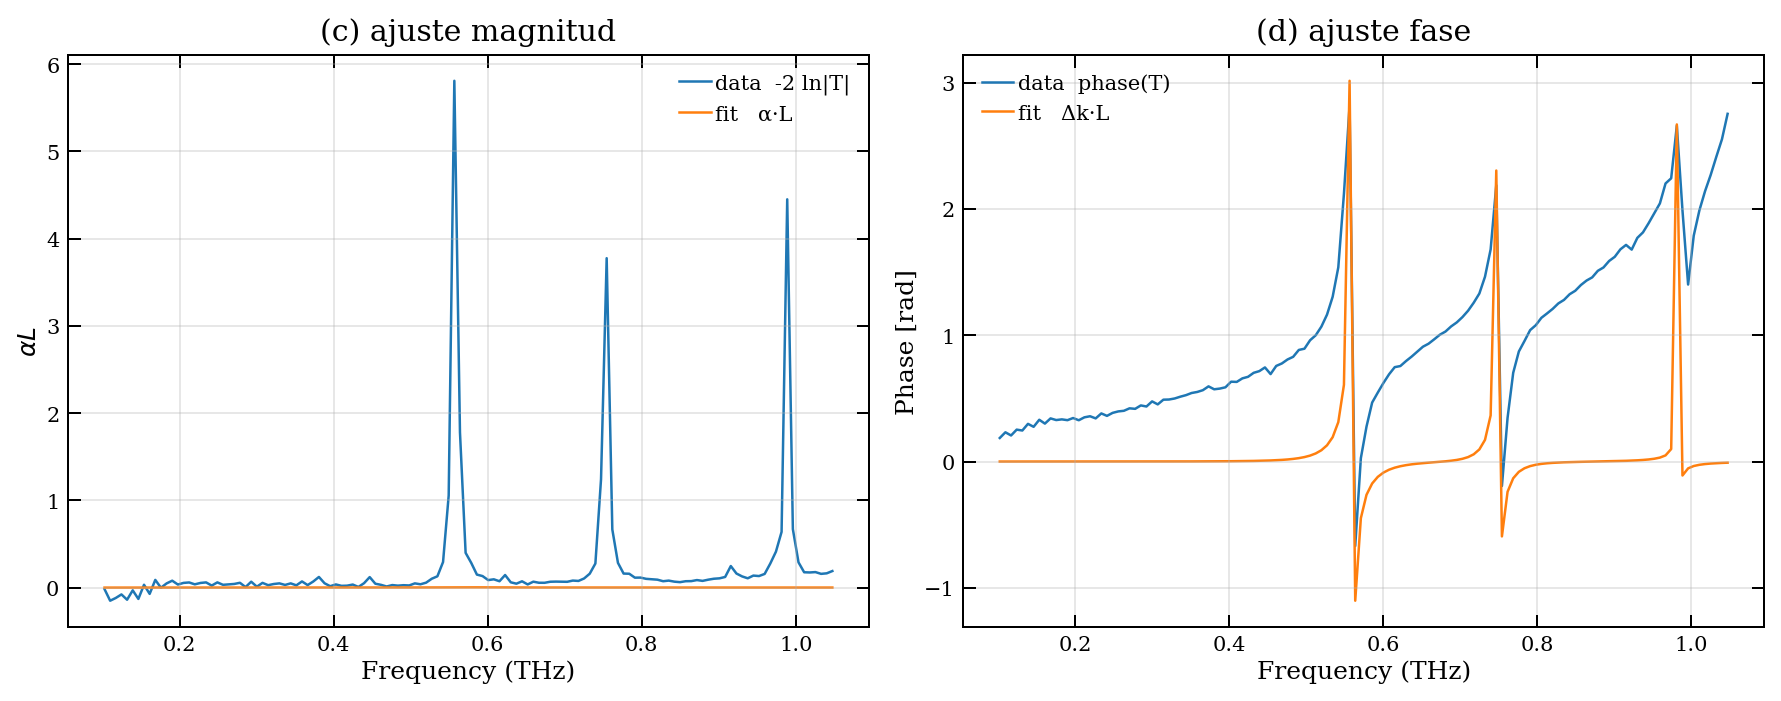

In [126]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

TWOPI, THz = 2*np.pi, 1

# --- Tus modelos (sin cambios) ---
def alpha_model(f_THz, f0_THz, Aj, gamma_frac, D=1.0):
    w  = TWOPI * (np.asarray(f_THz) * THz)[None, :]
    wj = TWOPI * (np.asarray(f0_THz) * THz)[:, None]
    Aj = np.asarray(Aj)[:, None]
    dOj = np.asarray(gamma_frac)[:, None] * wj

    denom_m = (w - wj)**2 + (dOj/2)**2
    denom_p = (w + wj)**2 + (dOj/2)**2
    pref = D * (Aj/np.pi) * (w/wj)**2
    term = dOj/denom_m + dOj/denom_p
    return np.sum(pref * term, axis=0)

def delta_k_model(f_THz, f0_THz, Aj, gamma_frac, D=1.0):
    w  = TWOPI * (np.asarray(f_THz) * THz)[None, :]
    wj = TWOPI * (np.asarray(f0_THz) * THz)[:, None]
    Aj = np.asarray(Aj)[:, None]
    #print(Aj)#
    dOj = np.asarray(gamma_frac)[:, None] * wj

    denom_m = (wj - w)**2 + (dOj/2)**2
    denom_p = (wj + w)**2 + (dOj/2)**2

    core = (wj**2 - w**2)
    tiny = np.finfo(float).tiny
    core_safe = np.where(np.isclose(core, 0.0), np.copysign(tiny, core), core)

    base = (2.0 * Aj) / (np.pi * wj) * (w * wj) / core_safe
    corr = 1.0 - (dOj**2) / (8.0 * wj**2) * (w / wj)
    bracket = ((wj + w)/denom_m) - ((wj - w)/denom_p)
    return (D * np.sum(base * corr * bracket, axis=0)).squeeze()

# --- Ajuste conjunto con curve_fit ---
def fit_three_lines_curvefit(
    nu_THz, T_complex, *,
    n_lines=3,
    f0_init=None, A_init=None, gamma_frac_init=None,
    D_init=1.0, L=1.0, unwrap_phase=True,
    f0_bounds=(0.15, 1.20), A_bounds=(0.0, np.inf), gamma_bounds=(1e-4, 0.2), D_bounds=(1e-6, np.inf),
    weights=(1.0, 1.0), eps_mag=1e-12
):
    f = np.asarray(nu_THz)
    T = np.asarray(T_complex)

    # Datos objetivo (robustos)
    mag = -2.0 * np.log(np.abs(T))       # ≈ α L
    phase = np.angle(T)
    if unwrap_phase:
        phase = np.unwrap(phase)                                  # ≈ Δk L

    f, mag, phase = f, mag, phase
    N = f.size

    # xdata/ydata apilados para curve_fit (modelo devuelve concatenado)
    xdata = np.concatenate([f, f])                 # (2N,)
    ydata = np.concatenate([mag, phase])           # (2N,)



    p0 = np.r_[np.asarray(f0_init, float),
               np.asarray(A_init, float),
               np.asarray(gamma_frac_init, float),
               float(D_init)]

    lower = np.r_[np.full(n_lines, f0_bounds[0]),
                  np.full(n_lines, A_bounds[0]),
                  np.full(n_lines, gamma_bounds[0]),
                  D_bounds[0]]
    upper = np.r_[np.full(n_lines, f0_bounds[1]),
                  np.full(n_lines, A_bounds[1]),
                  np.full(n_lines, gamma_bounds[1]),
                  D_bounds[1]]

    # Modelo concatenado para curve_fit
    def model_concat(x, *p):
        f0 = np.array(p[:n_lines])
        A  = np.array(p[n_lines:2*n_lines])
        g  = np.array(p[2*n_lines:3*n_lines])
        D  = float(p[-1])
        n = x.size // 2
        f1 = x[:n]   # para αL
        f2 = x[n:]   # para ΔkL (misma malla)
        alphaL = alpha_model(f1, f0, A, g, D=D) * L
        dkL    = delta_k_model(f2, f0, A, g, D=D) * L
        return np.concatenate([alphaL, dkL])

    popt, pcov = curve_fit(
        model_concat, xdata, ydata,
        p0=p0, bounds=(lower, upper), maxfev=100000
    )

    f0 = popt[:n_lines]
    A  = popt[n_lines:2*n_lines]
    g  = popt[2*n_lines:3*n_lines]
    D  = popt[-1]

    alpha_fitL = alpha_model(f, f0, A, g, D=D) * L
    dk_fitL    = delta_k_model(f, f0, A, g, D=D) * L

    return {
        "f_THz": f,
        "alphaL_meas": mag, "phase_meas": phase,
        "alphaL_fit": alpha_fitL, "phase_fit": dk_fitL,
        "params": {"f0_THz": f0, "Aj": A, "gamma_frac": g, "D": D},
        "cov": pcov
    }

# -----------------------
# USO con tus arrays
# -----------------------
# nu_filtradas: (N,)   ;   T: (N,) complejo
out = fit_three_lines_curvefit(
    nu_THz=nu_filtradas, T_complex=T,
    n_lines=3,
    f0_init=[0.557, 0.752, 0.988],
    A_init=[10,1,0.5],
    gamma_frac_init=[1e-2, 1e-4, 1e-2],  # Fracción de ancho de línea
    D_init=1.0,   # tus semillas
    L=1.0, unwrap_phase=False,
    weights=(1.0, 1.0)
)

print("Parámetros ajustados (curve_fit):")
print("f0 (THz)   :", out["params"]["f0_THz"])
print("A_j        :", out["params"]["Aj"])
print("gamma_frac :", out["params"]["gamma_frac"])
print("D          :", out["params"]["D"])

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=180, sharex=True)
ax1, ax2 = axs
ax1.plot(out["f_THz"], out["alphaL_meas"], label="data  -2 ln|T|")
ax1.plot(out["f_THz"], out["alphaL_fit"],  label="fit   α·L")
ax1.set_xlabel("Frequency (THz)"); ax1.set_ylabel(r"$\alpha L$")
ax1.set_title("(c) ajuste magnitud"); ax1.grid(alpha=0.3); ax1.legend()

ax2.plot(out["f_THz"], out["phase_meas"], label="data  phase(T)")
ax2.plot(out["f_THz"], out["phase_fit"],  label="fit   Δk·L")
ax2.set_xlabel("Frequency (THz)"); ax2.set_ylabel("Phase [rad]")
ax2.set_title("(d) ajuste fase"); ax2.grid(alpha=0.3); ax2.legend()
plt.tight_layout(); plt.show()
